# Exploration of Document Clustering with SPECTER embeddings

## Introduction

Cohan et al. have recently described in their new paper "SPECTER: Document-level Representation Learning using
Citation-informed Transformers" a methodology for training a BERT-like model that is informed by citations between scientific documents. Typically, BERT-like models and other Natural Language models (LMs) are used to represent semantic spaces -- they learn to embed meaning into high dimensional vector spaces. These vectors can be clustered to generate labels, for they can be used from similarity ranking, information retrieval, named entity recognition, lots of things. 

### Why typical LMs don't represent documents well 

But there's a problem: the longer the text, the more information you need to store, and these embeddings don't scale up to include additional information. You get 300 (or 500, or 768, or 1024...) dimensions for one bit of text, and that's it. A word, a sentence, a paragraph, or a document will all be the result of some kind of averaging function of th evectors of the text's individual pieces. So if you try to get a document embedding from the semantic average of the paper, well... imagine having partying 100 days in a row, all very distinct experiences. But when you try to remember them all years later, it's just a big fuzzy blob. The same principal applies to semantic embeddings. We're trying to fit 2000 sentences into 1000 32-bit floats. 

### Why not just use TF-IDF? 

We have! TF-IDF is a great way to create features from words in the corpus, rank them by importance per document, synthesize topics, and lots of other stuff. But we run into slightly different problems. It's difficult to use TF-IDF as the only method for clustering documents based on similarity, and it can vary heavily based on the language used by different researchers. Lemmatization of biological texts is tricky, and while we can assume TF-IDF measures will get us farther than nothing, it's incredibly difficult to (in an unsupervised way) get the clusters you want. You could get clusters based on mentions of distinct diseases, or based on experimental methods, or something entirely different. That's great; we need that. But we also need to understand how papers relate to one another, which is not going to be captured by TF-IDF matrices no matter which way you slice them.

### Can we generate features features based on SPECTER embeddings?

At CoronaWhy, we've wanted to model the different types of papers provided by Allen AI in an attempt to build a knowledge discovery system for COVID-19-related literature. However, we've been limited by a lack of domain-expert annotators (who wants to label 50,000 documents anyway?!), a deep understanding of the structure of all these papers as they relate to each other, and a lack of observable features to use in downstream ML tasks. However...

<blockquote>"Unlike most existing LMs that are “fine-tuning based”, our approach results in embeddings that can be applied to downstream tasks in a “feature-based” fashion, meaning the learned paper embeddings can be easily used as features, with no need for further task-specific fine-tuning. <br>
- Cohan, A., Feldman, S., Beltagy, I., Downey, D., & Weld, D. S. (2020). Document-level Representation Learning using Citation-informed Transformers. arXiv preprint arXiv:2004.07180.</blockquote>

So let's see what features we can come up with! 

## Import and Clean Data

In [128]:
import pandas as pd
from tqdm.notebook import tqdm

SPECTER isn't yet open-source, but you can access it via API. See here: 
https://github.com/allenai/paper-embedding-public-apis

Thankfully, Allen AI have provided us with embeddings for the documents in CORD-19 already. Check out the kaggle dataset for this file. 

In [7]:
dataset = pd.read_csv('./cord_19_embeddings_4_17.csv', header=None)
dataset.rename(columns={0:"cord_uid"}, inplace=True)

# Creating a duplicate dataset to work on, you can disable this if you're 
# short on memory
dataset1 = dataset

,1,2,3,4,5,6,7,8,9,10,...,759,760,761,762,763,764,765,766,767,768
count,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,...,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000,52398.000000
mean,-1.580658,-4.651966,0.331301,5.805071,1.479690,-1.821272,0.420131,0.299621,0.279545,-0.089719,...,0.358106,1.671745,1.438277,1.435674,-1.763050,-3.185653,2.150406,1.747885,-0.984236,-0.408342
std,2.254403,1.850991,2.167286,2.787206,2.128799,1.984251,1.903856,2.306024,1.725681,2.026352,...,2.022059,2.130496,2.896552,2.031910,2.098742,2.168608,1.671644,3.726150,2.097165,2.049996
min,-10.613510,-12.400436,-9.704121,-5.308089,-6.907209,-9.942760,-7.888433,-10.266559,-7.384149,-7.693954,...,-7.610225,-7.518122,-9.960460,-8.557096,-10.743165,-11.417212,-6.161361,-12.466450,-10.145894,-9.696711
25%,-3.163110,-5.909176,-1.124220,4.018937,0.017583,-3.180315,-0.830485,-1.343975,-0.849849,-1.560681,...,-1.054428,0.138223,-0.431328,0.128325,-3.080847,-4.740505,0.963256,-0.121725,-2.303027,-1.690583
50%,-1.562077,-4.700013,0.404314,6.195546,1.453257,-1.933062,0.378683,0.338024,0.324741,-0.089020,...,0.245212,1.666868,1.777820,1.375599,-1.581578,-3.250225,2.152531,2.621245,-0.924977,-0.377122
75%,-0.021774,-3.450440,1.876435,7.836147,2.941536,-0.578279,1.697904,1.921544,1.410066,1.332563,...,1.746730,3.169564,3.535143,2.718488,-0.307045,-1.613375,3.278984,4.387155,0.425949,0.873703
max,8.813931,4.856503,9.439322,14.173829,10.539775,6.672823,8.344262,8.461172,8.572489,8.533588,...,8.528946,10.956348,10.829283,9.849207,6.044204,4.874840,9.956749,12.171288,7.731287,8.014271


### Generic unsupervised cluster magic sauce

We don't know how many clusters we have, and we don't have a focus group to tell us how scientific papers are all related, what categories they should fit into, or anything else. We also don't _exactly_ know how SPECTER has learned to model papers yet, so we need to do some very hopeful, very unsupervised clustering and get to the bottom of this. 

K-Means is very powerful and simple. It's a tool that's second-nature to lots of data scientists, and while there's lots of different clustering methods we can try, let's go with Occam's Razor for now. After all, we don't want to wait forever! 

So what we'll do here is try many different numbers of clusters, between 2 and 20. We'll use what's known as the "Elbow Method" to make an informed guess as to the structure of our data. K-means will try to cluster the data into *n* groups, and measure the distortion of each of those clusters. Then, we'll iteratively increase how many clusters we want to try, again measuring distortion. By plotting the distortion as a function of cluster count, we can see where we might want to start exploring further. There should be a steep line downward, followed by a smoothing out/bend in the graph as adding more clusters slowly decreases distortion. 

In [123]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,20))

/root/anaconda3/envs/covid/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ab86ffad0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


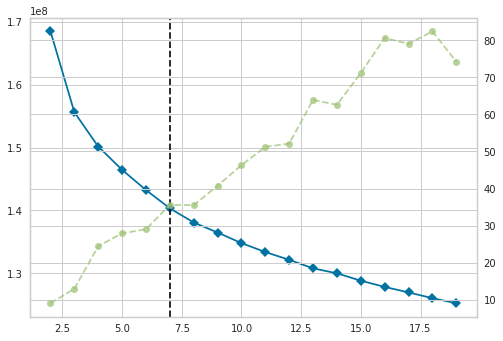

In [124]:
visualizer.fit(dataset.drop(columns=["cord_uid"]))
visualizer.show()        # Finalize and render the figure

So it looks like we're going to start with 7 clusters! 

#### Author's note:
before discovering this handy "yellowbrick" package I was just eye-balling the number based on the graph. I tried 6, and diagnostic tests showed that one of the clusters really should have been broken in two. At ten, the structure is a lot more difficult to follow. I'm excited to see how this looks. 

Also, I modified a lot of the k-means code from this page: https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca
Because I'm too lazy to write it myself. Just changed a few variables here and there :) 

In [131]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset1.drop(columns=["cord_uid"]))

# Beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding clusters labels to the dataset
dataset1['cluster'] = cluster

Now that we've got out clusters and labels in place, we can start using some visualization tools to check out the quality of the groups. This is an important exploratory step for understanding the structure (or lack of structure) in your data, and can inform how you continue processing it, or if you need to go back to the drawing board. 

My visualization technique of choice for embeddings is UMAP -- it tends to look nice and preserve inter-cluster distances and relationships better than t-SNE. But whether we can use UMAP and t-SNE for the actual clustering is a matter of discussion, so I prefer to leave that part to K-means. If we were working with a sparse matrix in a text corpus, I might have started with pyLDAvis. But I digress.

## UMAP visualizations and quality check

In [132]:
import numpy as np
import umap
import umap.plot

In [133]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(28,20)})

Some of these algorithms are quite heavy-- especially any visualizations that involve drawing connected graphs. As long as it's not really affecting our data, it'll be nice to have a scaled down version of the dataset to work with for those heavier processes.

In [134]:
dataset2 = dataset1.sample(frac=0.1, random_state=1)

In [135]:
mapper = umap.UMAP().fit(dataset1.drop(columns=["cord_uid", "cluster"]), y=dataset1.cluster)
small_mapper = umap.UMAP().fit(dataset2.drop(columns=["cord_uid", "cluster"]), y=dataset2.cluster)

### Generic UMAP plot

This actually looks unusually clean. A few outliers, but nicely distributed clusters.

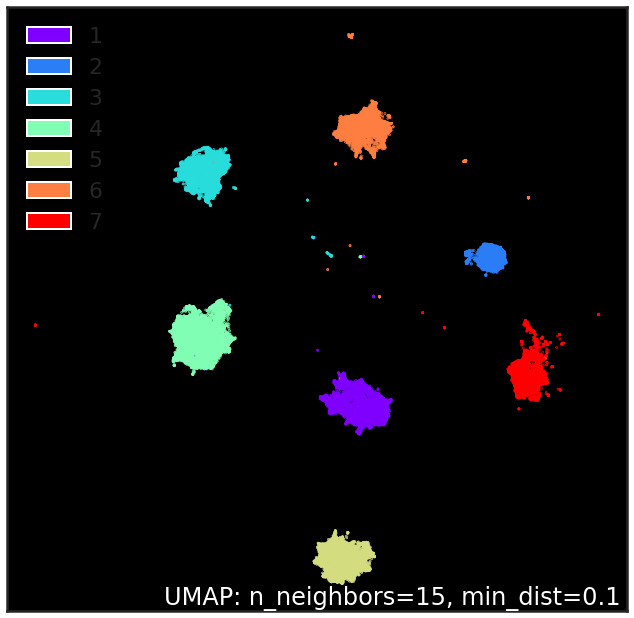

In [152]:
umap.plot.points(mapper, labels=dataset1.cluster, theme='fire')

## Cluster Diagnostics

We need to run some diagnostics and additional visualizations to make sure these clusters are well-formed. 


### Connectivity Plot

From the UMAP documentation: 

"UMAP works by constructing an intermediate topological representation of the approximate manifold the data may have been sampled from. In practice this structure can be simplified down to a weighted graph. Sometimes it can be beneficial to see how that graph (representing connectivity in the manifold) looks with respect to the resulting embedding."

Here we can see that there's 5 clusters that seem to have a greater degree of connection with each other than they do with the two outlying groups. It'll be interesting to see if this translates to observable features in the data.

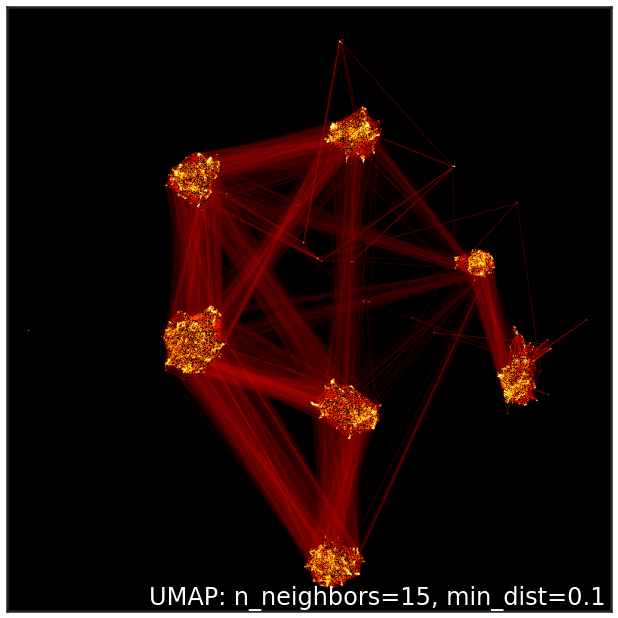

In [188]:
umap.plot.connectivity(mapper, show_points=True, theme="fire")

### PCA Plot

PCA works by reducing the embedding dimension to 3 (in this case), where color represents the Z axis. PCA isn't perfect of course (we're reducing more than 700 dimensions down to 3), but ideally here we want to see a smooth color transition in any of the clusters. If there's anything wrong, there could be a really sudden or jarring transition in the middle of a cluster from red to blue, or something. 

Apart from the smaller reddish brownish yellow cluster, these all look pretty ok. 

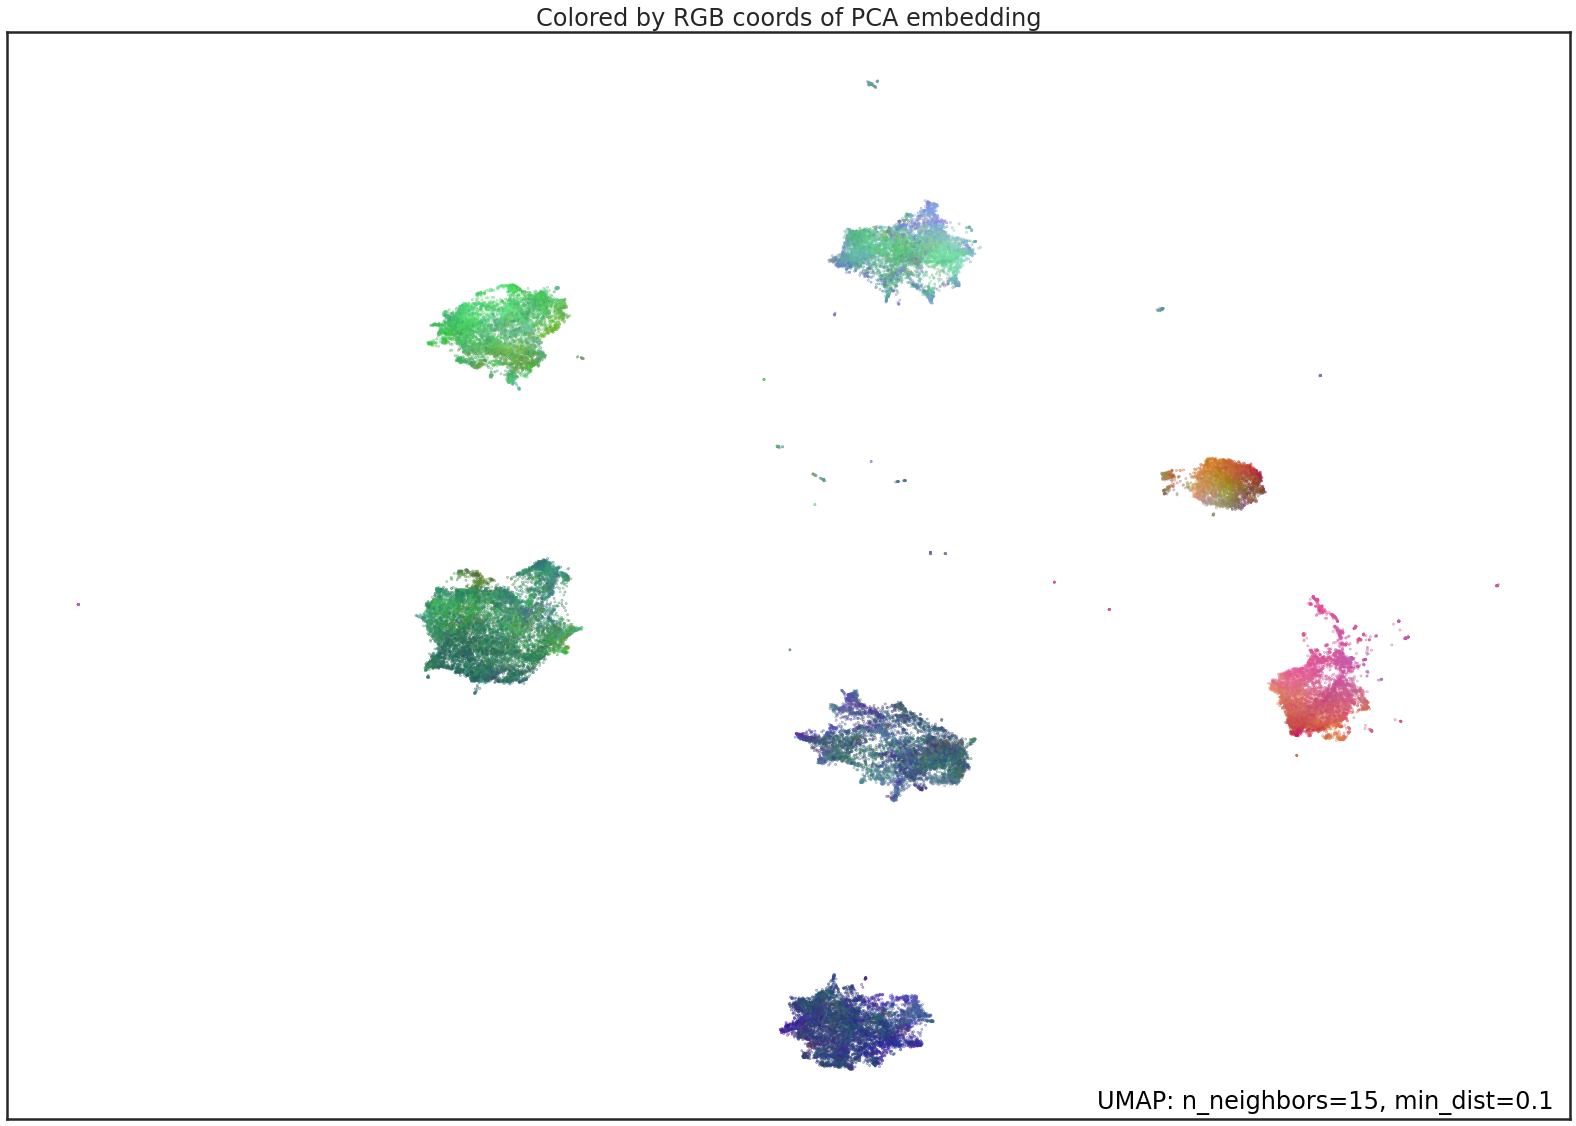

In [168]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

### Vector Quantization Plot

We basically want to see the same thing here. Smooth transition of colors, with not much variation of coloration within clusters. And again, apart from the smallest cluster, it looks like we have some pretty decent visual representations of the embedding space. What a relief! 

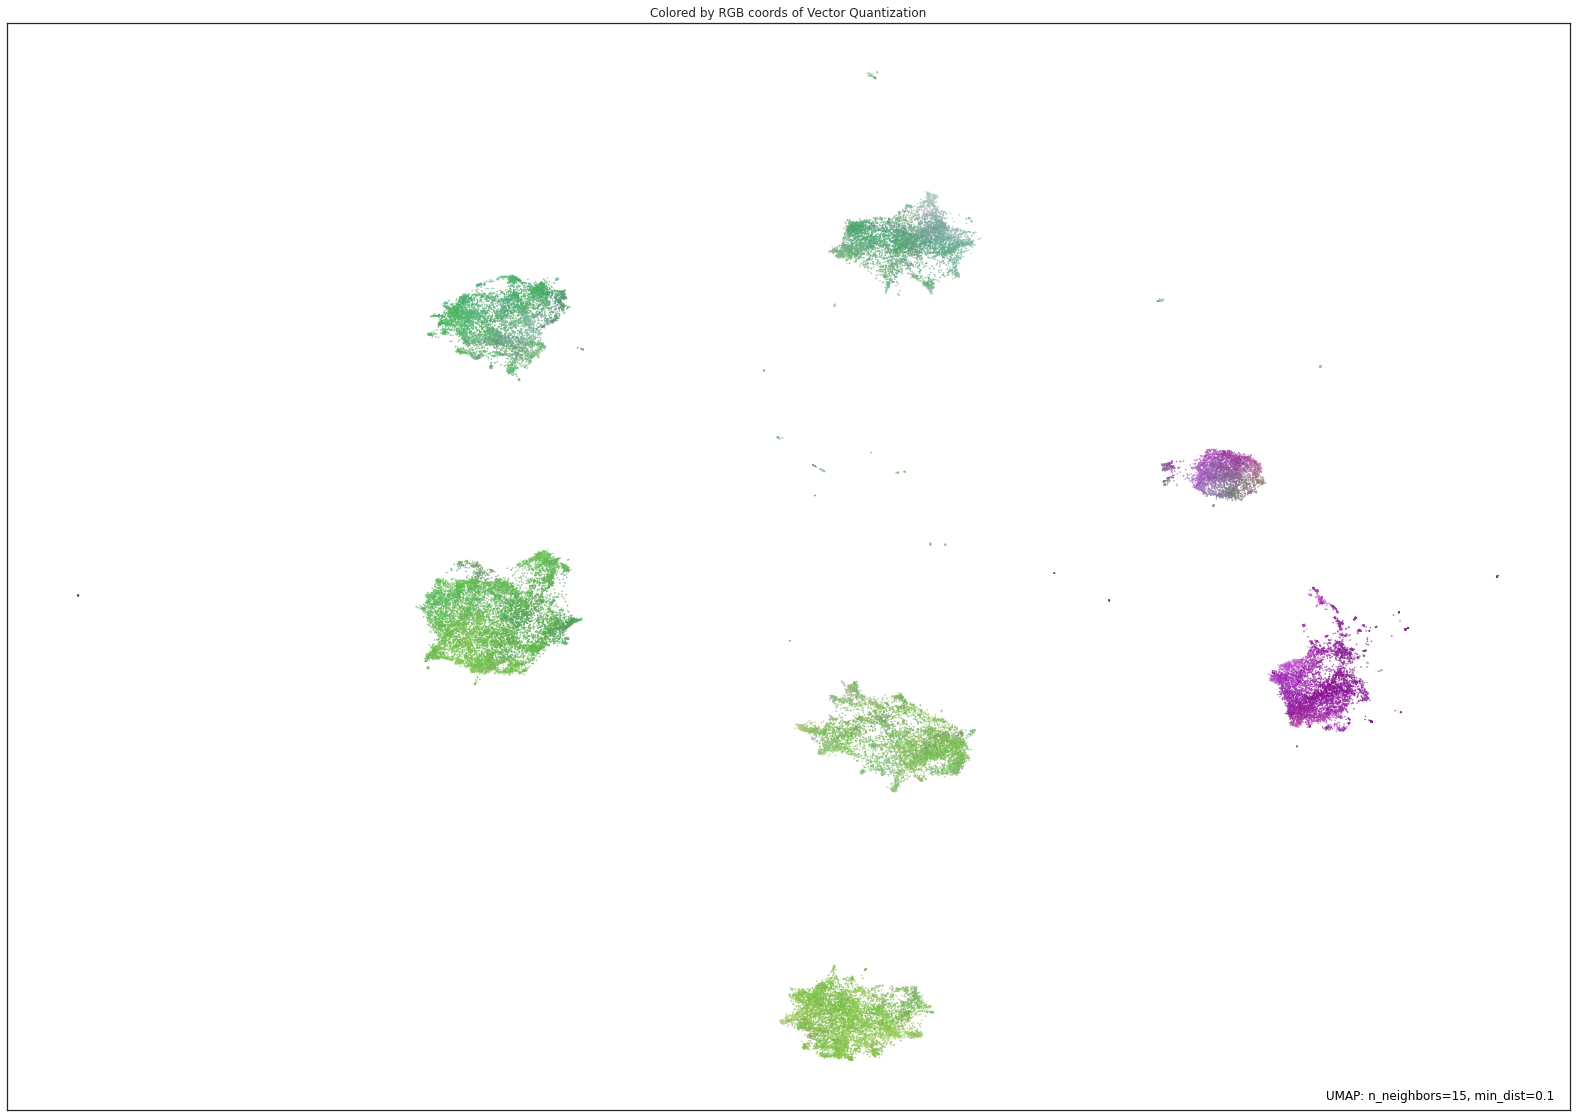

In [139]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

## Sanity check - What about those 6 and 10 cluster models?

Like I mentioned earlier, I tried looking at just 6 clusters, but it became clear that one of those clusters wasn't well-formed. What if we superimpose the labels for our 7-cluster model to the 6-cluster one?

And what about our 10-cluster model? How would that look?

In [172]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset1.drop(columns=["cord_uid"]))

# Beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1

# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)

# Adding clusters labels to the dataset
dataset1['cluster_6'] = cluster

Text(0.5, 1.0, 'UMAP Clustering of SPECTER Embeddings')

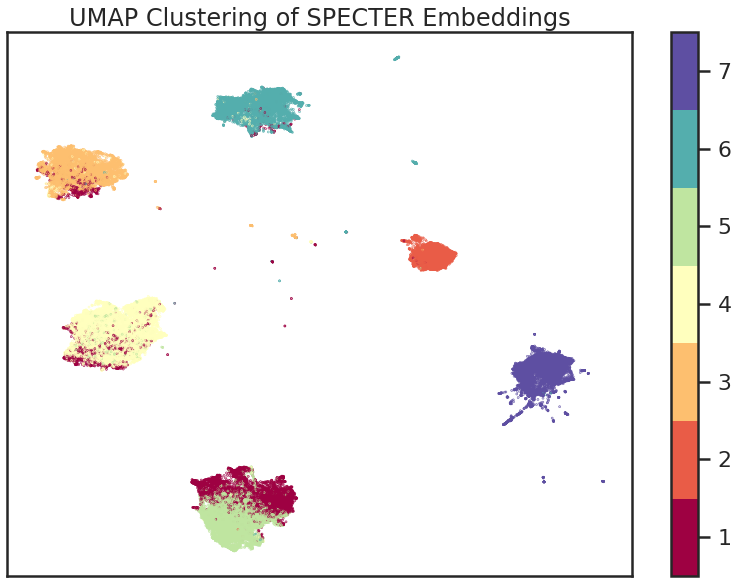

In [184]:
#embedding = umap.UMAP().fit_transform(dataset.drop(columns=["cord_uid"]), y=dataset1.cluster_6)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=dataset1.cluster, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(1,9)-.5)
cbar.set_ticks(np.arange(1,9))
cbar.set_ticklabels(sorted(dataset1.cluster.unique()))
plt.title('UMAP Clustering of SPECTER Embeddings')

Looks like our 7-th and final cluster is actually mostly pulled from the troublesome one I found earlier, and just a few points from a couple others. 

Text(0.5, 1.0, 'UMAP Clustering of SPECTER Embeddings')

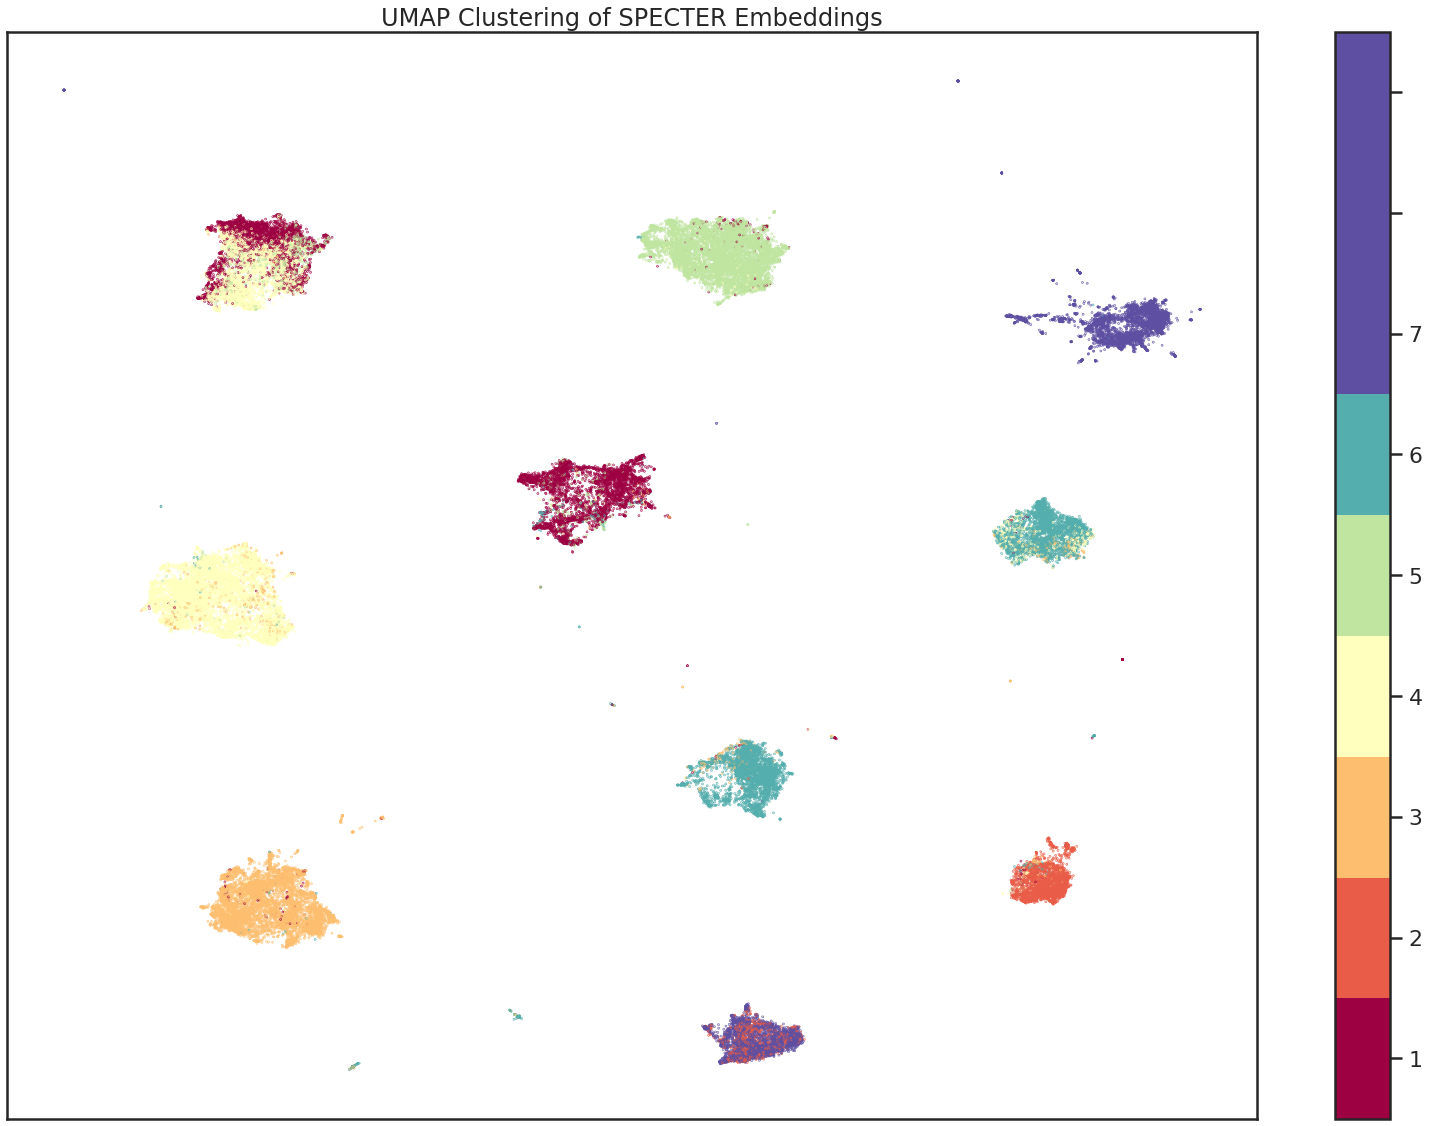

In [185]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset1.drop(columns=["cord_uid"]))

# Beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1

# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)

# Adding clusters labels to the dataset
dataset1['cluster_10'] = cluster

embedding = umap.UMAP().fit_transform(dataset.drop(columns=["cord_uid"]), y=dataset1.cluster_10)
fig, ax = plt.subplots(1, figsize=(28, 20))
plt.scatter(*embedding.T, s=0.3, c=dataset1.cluster, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(1,9)-.5)
cbar.set_ticks(np.arange(1,9))
cbar.set_ticklabels(sorted(dataset1.cluster.unique()))
plt.title('UMAP Clustering of SPECTER Embeddings')

Pretty cool! So it looks like we can stick with our 7-cluster model, given all the diagnostic checks, and this sanity check. 

To me, this suggests we might have 9 or 10 neatly divided topics. The weird thing is, most of these look equidistant from their next neighbors. My hunch is that we'll be able to divide some of the 7 clusters evenly in smaller sub clusters.

# What next?

Cool. We have our clusters. We've engineered some features based on the SPECTER embeddings. But for now, it's just numbers. What's the actual difference between those documents? Can we replicate these results in the text? Let's check it out in the next notebook.

In [198]:
dataset1[["cord_uid","cluster","cluster_6","cluster_10"]].to_csv("cord19clusters.csv", index=False)